# Music classification - Group 17

# Task 1

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score
import seaborn as sns


In [118]:
# Feature extraction
data = pd.read_csv('Classification music/GenreClassData_30s.txt', delimiter="\t")
data = data.drop(columns=["File"])
test_data = data[data["Type"] == "Test"]
train_data = data[data["Type"] == "Train"]

# Only want the headers spectral rolloff mean, mfcc 1 mean, spectral centroid mean and tempo
X_train = train_data[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean", "tempo"]]
y_train = train_data["GenreID"]
X_test = test_data[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean", "tempo"]]
y_test = test_data["GenreID"]


In [119]:
## K-nearest neighbor

def KNN(X_train, y_train, X_test, k=5):
    y_pred = []
    for i in range(len(X_test)):
        xi = X_test.iloc[i].values
        distance = np.zeros(len(X_train.iloc[:, 0]))
        for j in range(len(xi)):
            distance += (xi[j] - X_train.iloc[:, j])**2
        euclidian_dist = np.sqrt(distance)
        
        smallest_indices = np.argsort(euclidian_dist)[:k]
        genre_of_smallest_indices = y_train[smallest_indices]   
        y_pred_i, _ = Counter(genre_of_smallest_indices).most_common(1)[0]
        y_pred.append(y_pred_i)
    return y_pred


y_pred = KNN(X_train, y_train, X_test, k=5)


Precision:  0.3827402283706631
Accuracy:  0.37373737373737376


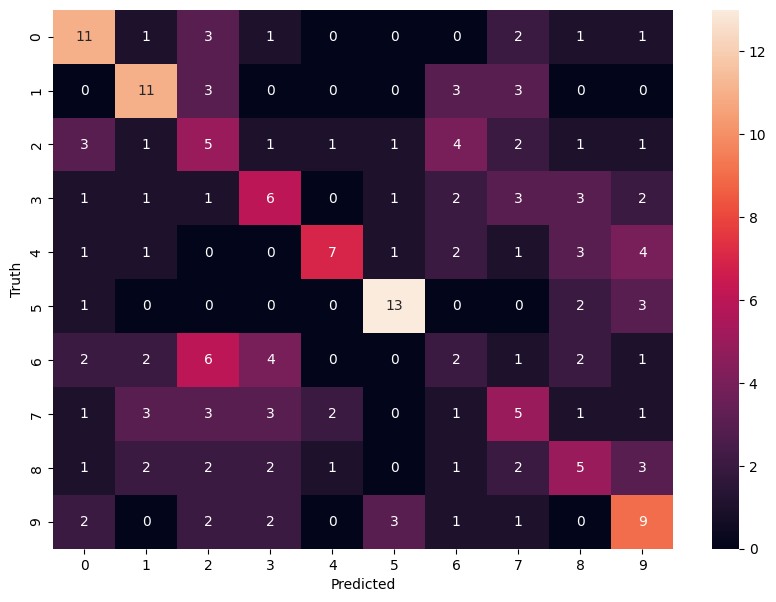

In [ ]:
# Calculate precision and accuracy
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_test, y_pred))

#Compare result as a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


# Task 2

In [ ]:
## Plotting some
pop_data = train_data[train_data["Genre"] == "pop"]
disco_data = train_data[train_data["Genre"] == "disco"]
metal_data = train_data[train_data["Genre"] == "metal"]
classical_data = train_data[train_data["Genre"] == "classical"]

# Spectral rolloff mean
plt.figure(figsize=(6,4))
plt.plot(
    pop_data["spectral_rolloff_mean"], pop_data["Track ID"], 'ro',
    disco_data["spectral_rolloff_mean"], disco_data["Track ID"], 'bo',
    metal_data["spectral_rolloff_mean"], metal_data["Track ID"], 'go',
    classical_data["spectral_rolloff_mean"], classical_data["Track ID"], 'yo'
)
plt.xlabel("spectral_rolloff_mean")
plt.ylabel("Track ID")
plt.title("spectral_rolloff_mean")
plt.legend(["pop", "disco", "metal", "classical"])
plt.show()

# mfcc 1 mean
plt.figure(figsize=(6,4))
plt.plot(
    pop_data["mfcc_1_mean"], pop_data["Track ID"], 'ro',
    disco_data["mfcc_1_mean"], disco_data["Track ID"], 'bo',
    metal_data["mfcc_1_mean"], metal_data["Track ID"], 'go',
    classical_data["mfcc_1_mean"], classical_data["Track ID"], 'yo'
)
plt.xlabel("mfcc_1_mean")
plt.ylabel("Track ID")
plt.title("mfcc_1_mean")
plt.legend(["pop", "disco", "metal", "classical"])
plt.show()

# spectral centroid mean
plt.figure(figsize=(6,4))
plt.plot(
    pop_data["spectral_centroid_mean"], pop_data["Track ID"], 'ro',
    disco_data["spectral_centroid_mean"], disco_data["Track ID"], 'bo',
    metal_data["spectral_centroid_mean"], metal_data["Track ID"], 'go',
    classical_data["spectral_centroid_mean"], classical_data["Track ID"], 'yo'
)
plt.xlabel("spectral_centroid_mean")
plt.ylabel("Track ID")
plt.title("spectral_centroid_mean")
plt.legend(["pop", "disco", "metal", "classical"])
plt.show()

# tempo
plt.figure(figsize=(6,4))
plt.plot(
    pop_data["tempo"], pop_data["Track ID"], 'ro',
    disco_data["tempo"], disco_data["Track ID"], 'bo',
    metal_data["tempo"], metal_data["Track ID"], 'go',
    classical_data["tempo"], classical_data["Track ID"], 'yo'
)
plt.xlabel("tempo")
plt.ylabel("Track ID")
plt.title("tempo")
plt.legend(["pop", "disco", "metal", "classical"])
plt.show()


We can clearly see that tempo is the feature which is least seperable, meaning it will have little impact on the final classification. The other three fetaures are also quite inseperable for pop, metal and disco, which can explain the poor performance using only these features. Logically we would want to remove tempo as a feature, which is further backed by the findings in task 3

# Task 3

In [123]:
x_train_data = train_data.drop(columns=["Genre","GenreID", "Type", "Track ID"])
x_test_data = test_data.drop(columns=["Genre","GenreID", "Type", "Track ID"])

# Scale all data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_data_scaled = scaler.fit_transform(x_train_data)
x_test_data_scaled = scaler.transform(x_test_data)

x_train_data_scaled = pd.DataFrame(x_train_data_scaled, columns=x_train_data.columns)
x_test_data_scaled = pd.DataFrame(x_test_data_scaled, columns=x_test_data.columns)

y_train_data = train_data["GenreID"]
y_test_data = test_data["GenreID"]

In [ ]:
# Find which of the 4 features we should remove
X_train_scaled = x_train_data_scaled[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean","tempo"]]
X_test_scaled = x_test_data_scaled[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean", "tempo"]]

accuracies = []

for remaining_feature in X_train_scaled.columns.values:
    X_train_scaled_temp = X_train_scaled.drop(columns=[remaining_feature])
    X_test_scaled_temp = X_test_scaled.drop(columns=[remaining_feature])
    y_pred =  KNN(X_train_scaled_temp, y_train_data, X_test_scaled_temp, k=5)
    accuracy = accuracy_score(y_test_data, y_pred)
    accuracies.append(accuracy)

worst_feature = X_train_scaled.columns.values[accuracies.index(max(accuracies))]
print("Best feature to remove: ", worst_feature)
print("Accuracy when removing that feature: ", max(accuracies))

Best feature to remove:  tempo
Accuracy when removing that feature:  0.3939393939393939


In [ ]:
# Implement forward selection to find most important features
X_train_scaled = x_train_data_scaled[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean"]]
X_test_scaled = x_test_data_scaled[["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean"]]

x_train_remaining_features = x_train_data_scaled.drop(columns=["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean"])
x_test_remaining_features = x_test_data_scaled.drop(columns=["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean"])
accuracies = []

for remaining_feature in x_train_remaining_features.columns.values:
    X_train_scaled_temp = X_train_scaled.join(x_train_remaining_features[remaining_feature])
    X_test_scaled_temp = X_test_scaled.join(x_test_remaining_features[remaining_feature])
    y_pred =  KNN(X_train_scaled_temp, y_train_data, X_test_scaled_temp, k=5)
    accuracy = accuracy_score(y_test_data, y_pred)
    accuracies.append(accuracy)

best_feature = x_train_remaining_features.columns.values[accuracies.index(max(accuracies))]
print("Best feature to add: ", best_feature)
print("Accuracy with that feature: ", max(accuracies))

Best feature to add:  rmse_var
Accuracy with that feature:  0.51010101010101


Precision:  0.5058097699402048
Accuracy:  0.51010101010101


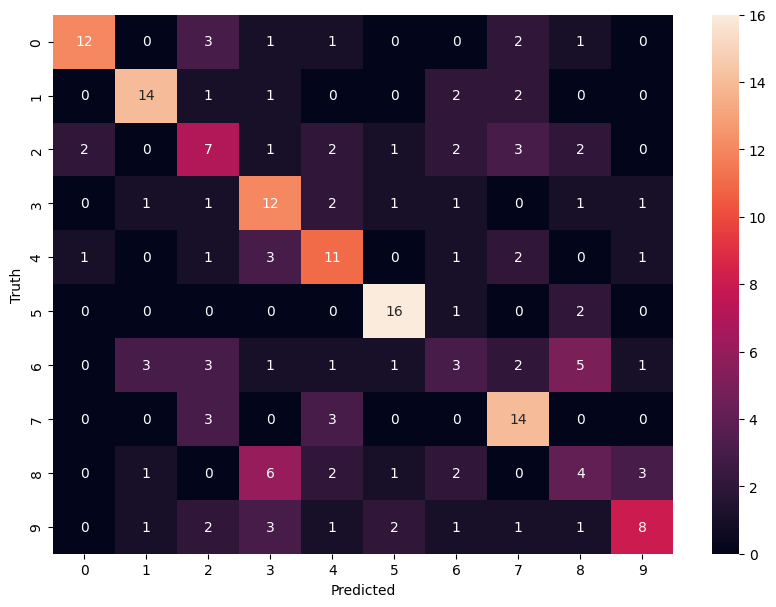

In [ ]:
y_pred = KNN(X_train_scaled.join(x_train_remaining_features[best_feature]), y_train_data, X_test_scaled.join(x_test_remaining_features[best_feature]), k=5)

# Calculate precision and accuracy
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_test, y_pred))

#Compare result as a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


# Task 4

In [ ]:
# Find most important features using forward selection
X_train_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()
x_train_remaining_features = x_train_data_scaled
x_test_remaining_features = x_test_data_scaled

for i in range (10):
    accuracies = []
    if i == 0:
        for remaining_feature in x_train_remaining_features.columns.values:
            xtr = x_train_remaining_features[remaining_feature]
            xtr = pd.DataFrame(xtr)
            xte = x_test_remaining_features[remaining_feature]
            xte = pd.DataFrame(xte)
            y_pred =  KNN(xtr, y_train_data, xte, k=5)
            accuracy = accuracy_score(y_test_data, y_pred)
            accuracies.append(accuracy)
        best_feature = x_train_remaining_features.columns.values[accuracies.index(max(accuracies))]
        X_train_scaled = pd.DataFrame(x_train_remaining_features[best_feature])
        X_test_scaled = pd.DataFrame(x_test_remaining_features[best_feature])
        x_train_remaining_features = x_train_remaining_features.drop(columns=[best_feature])
        x_test_remaining_features = x_test_remaining_features.drop(columns=[best_feature])
    else:
        for remaining_feature in x_train_remaining_features.columns.values:
            X_train_scaled_temp = X_train_scaled.join(x_train_remaining_features[remaining_feature])
            X_test_scaled_temp = X_test_scaled.join(x_test_remaining_features[remaining_feature])
            y_pred =  KNN(X_train_scaled_temp, y_train_data, X_test_scaled_temp, k=5)
            accuracy = accuracy_score(y_test_data, y_pred)
            accuracies.append(accuracy)
    
        best_feature = x_train_remaining_features.columns.values[accuracies.index(max(accuracies))]
        X_train_scaled = X_train_scaled.join(x_train_remaining_features[best_feature])
        X_test_scaled = X_test_scaled.join(x_test_remaining_features[best_feature])
        x_train_remaining_features = x_train_remaining_features.drop(columns=[best_feature])
        x_test_remaining_features = x_test_remaining_features.drop(columns=[best_feature])

print(max(accuracies))

KeyboardInterrupt: 

In [158]:
# Fetch data
data_30 = pd.read_csv('Classification music/GenreClassData_30s.txt', delimiter="\t")
data_10 = pd.read_csv('Classification music/GenreClassData_10s.txt', delimiter="\t")
data_5 = pd.read_csv('Classification music/GenreClassData_5s.txt', delimiter="\t")

data = pd.concat([data_30, data_10, data_5], axis=0).reset_index(drop=True)

data = data_5.drop(columns=["File"])
test_data = data[data["Type"] == "Test"]
train_data = data[data["Type"] == "Train"]

x_train_data = train_data.drop(columns=["Genre","GenreID", "Type", "Track ID"])
x_test_data = test_data.drop(columns=["Genre","GenreID", "Type", "Track ID"])

# Scale all data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_data_scaled = scaler.fit_transform(x_train_data)
x_test_data_scaled = scaler.transform(x_test_data)

x_train_data_scaled = pd.DataFrame(x_train_data_scaled, columns=x_train_data.columns)
x_test_data_scaled = pd.DataFrame(x_test_data_scaled, columns=x_test_data.columns)

y_train_data = train_data["GenreID"]
y_test_data = test_data["GenreID"]

In [155]:
print(len(data))
print(y_train_data[750:812])

9900
750     9
751     9
752     9
753     9
754     9
       ..
1005    0
1006    0
1007    0
1008    0
1009    0
Name: GenreID, Length: 62, dtype: int64


In [132]:
# The 10 best features to use are:
best_features = ['spectral_centroid_mean', 'zero_cross_rate_mean', 'rmse_var',
       'mfcc_5_std', 'mfcc_5_mean', 'mfcc_6_mean', 'spectral_contrast_mean',
       'rmse_mean', 'mfcc_4_mean', 'mfcc_4_std']

# Create a new dataframe with only the best features
X_train_scaled = x_train_data_scaled[best_features]
X_test_scaled = x_test_data_scaled[best_features]

# Do KNN
y_pred = KNN(X_train_scaled, y_train_data, X_test_scaled, k=5)

# Calculate precision and accuracy
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Compare result as a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

KeyError: '[811, 812] not in index'

In [157]:
# Forward and backward propagation

def relu_derivative(x):
    return (x > 0).astype(float).T

def backpropogation(features, y, y_pred, w1, b1, w2, nodes1):
    features = np.array(features)
    features = features[:, np.newaxis]

    dZ2 = y_pred - y
    dw2 = np.dot(nodes1,dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dA1 = np.dot(dZ2, w2.T)
    
    Z1 = np.dot(features.T, w1) + b1.T
    dZ1 = dA1*relu_derivative(Z1).T
    
    dw1 = np.dot(features, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)


    return dw1, dw2, db1.T, db2.T

    


def forwardpropogation(input_layer,weight, bias, num_layer, activation_function):
    if activation_function == "reLu":
        return np.maximum(np.zeros(num_layer), np.dot(input_layer.transpose(),weight)+bias.transpose()).transpose()
    
    if activation_function == "softmax":
        exp = np.exp(np.dot(input_layer.transpose(),weight)+bias.transpose())
        return exp/np.sum(exp).transpose()

    else:
        raise ValueError("Activation function not recognized")

In [110]:

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [159]:

feature_values = x_train_data_scaled
feature_values = feature_values.values

ground_truth_onehot = pd.get_dummies(y_train_data, prefix="GenreID")
ground_truth_onehot = ground_truth_onehot.values

ground_truth_onehot, feature_values = unison_shuffled_copies(ground_truth_onehot, feature_values)

validation_size = feature_values.shape[0] // 8


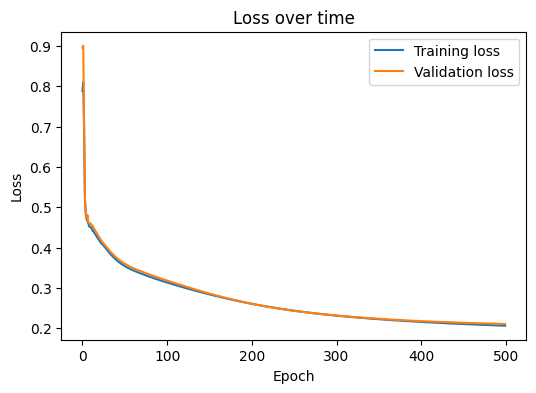

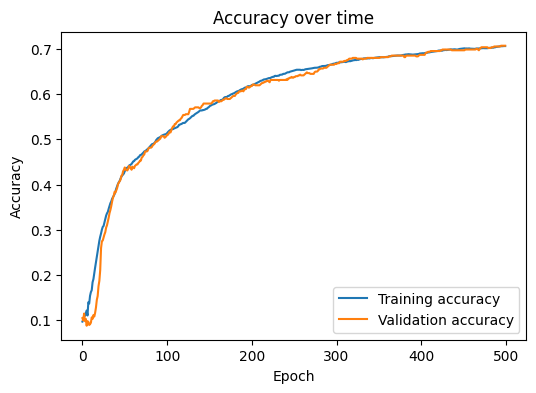

In [160]:
#init
np.random.seed(42)

num_features = feature_values.shape[1]
num_perc_layer1 = 8
num_output = ground_truth_onehot.shape[1]
learning_rate = 0.1
num_epochs = 500
batch_size = feature_values.shape[0] // 7
num_data = feature_values.shape[0] - validation_size

weights1 = np.random.rand(num_features, num_perc_layer1)
bias1 = np.random.rand(num_perc_layer1,1)
weights2 = np.random.rand(num_perc_layer1, num_output)
bias2 = np.random.rand(num_output,1)

losses = []
validation_losses = []
validation_accuracies = []
accuracies = []

dweights1sum = 0
dweights2sum = 0
dbias1sum = 0
dbias2sum = 0

for epoch in range(num_epochs):
       loss = 0
       validation_loss = 0
       val_predictions = []
       predictions = []

       for i in range(num_data):

              nodes1 = forwardpropogation(feature_values[i,:], weights1, bias1, num_perc_layer1, activation_function="reLu")
              output = forwardpropogation(nodes1, weights2, bias2, num_output, activation_function="softmax")

              #Calculate loss through squared error
              loss += np.sum((ground_truth_onehot[i]-output)**2)/2
              predictions.append(np.argmax(output))

              # Backpropogation
              dweights1, dweights2, dbias1, dbias2 = backpropogation(feature_values[i,:], ground_truth_onehot[i], output, weights1, bias1, weights2, nodes1)
              dweights1sum += dweights1
              dweights2sum += dweights2
              dbias1sum += dbias1
              dbias2sum += dbias2

              # Update weights and biases
              if i % batch_size == 0:
                     weights1 -= learning_rate*dweights1sum/batch_size
                     weights2 -= learning_rate*dweights2sum/batch_size
                     bias1 -= learning_rate*dbias1sum/batch_size
                     bias2 -= learning_rate*dbias2sum/batch_size
                     dweights1sum = 0
                     dweights2sum = 0
                     dbias1sum = 0
                     dbias2sum = 0
       
       losses.append(loss/num_data)
       accuracies.append(accuracy_score(np.argmax(ground_truth_onehot[:num_data], axis=1), predictions))
       #Validation
       for k in range(validation_size):
              nodes1 = forwardpropogation(feature_values[k+num_data,:], weights1, bias1, num_perc_layer1, activation_function="reLu")
              output = forwardpropogation(nodes1, weights2, bias2, num_output, activation_function="softmax")
              validation_loss += np.sum((ground_truth_onehot[k+num_data]-output)**2)/2
              val_predictions.append(np.argmax(output))

       validation_accuracy = accuracy_score(np.argmax(ground_truth_onehot[-validation_size:], axis=1), val_predictions)
       validation_accuracies.append(validation_accuracy)
       validation_losses.append(validation_loss/validation_size)

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.plot(validation_losses)
plt.legend(["Training loss", "Validation loss"])
plt.title("Loss over time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(accuracies)
plt.plot(validation_accuracies)
plt.legend(["Training accuracy", "Validation accuracy"])
plt.title("Accuracy over time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Precision:  0.6465024959038322
Accuracy:  0.6590909090909091


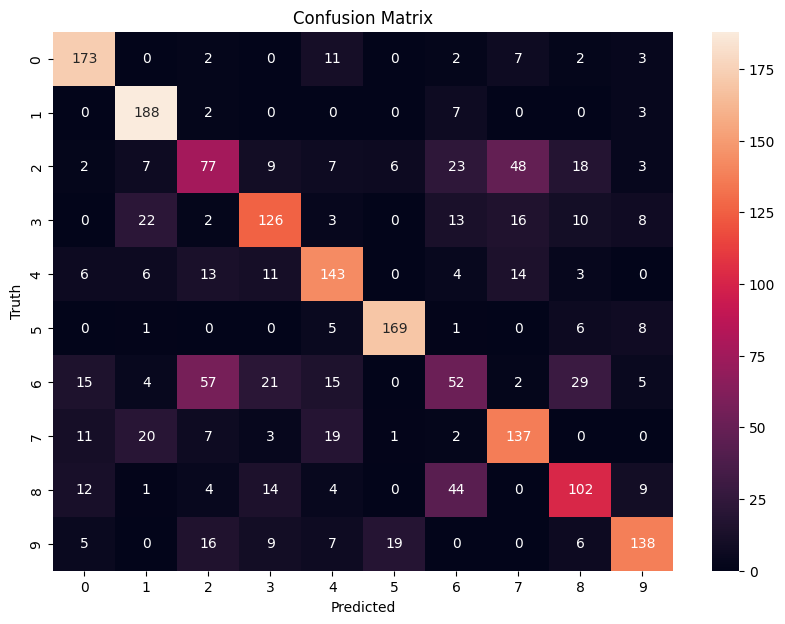

In [ ]:
# Test the model on the test data
feature_values_test = x_test_data_scaled
ground_truth_test = y_test_data


predictions = []
for i in range(len(feature_values_test)):
    nodes1 = forwardpropogation(feature_values_test.iloc[i].values, weights1, bias1, num_perc_layer1, activation_function="reLu")
    output = forwardpropogation(nodes1, weights2, bias2, num_output, activation_function="softmax")
    predictions.append(np.argmax(output))

# Calculate precision and accuracy
print("Precision: ", precision_score(ground_truth_test, predictions, average='macro'))
print("Accuracy: ", accuracy_score(ground_truth_test, predictions))

# Compare result as a confusion matrix
cm = confusion_matrix(ground_truth_test, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")
plt.show()
